In [7]:
# coding: utf-8
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.recurrent import LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import metrics

# CSVファイルから気象データをDataFrame型で取得する
def get_dfWeather_data():
    # 最初のカラム(年月日)をindexとし、最初の5行を読み飛ばす
    dfWeather = pd.read_csv('気温/2016-2017.csv', index_col=0, parse_dates=True, encoding = 'shift_jis', header=None)
    # 不要な列を削除する
    #dfWeather = dfWeather.drop([2, 3, 5, 6, 8, 9, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 30, 31, 32, 33, 35, 36, 38, 39, 41, 42, 44, 45, 47, 48, 50, 51, 53, 54, 55, 56, 57, 58, 59, 61, 62, 64, 65, 66], axis=1)
    dfWeather = dfWeather.drop([2, 3, 5, 6, 8, 9, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 35, 36, 38, 39, 41, 42, 44, 45, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 64, 65, 66], axis=1)
    # 列名を指定する
    '''
    dfWeather.columns = [
        'average_temperature',        # 平均気温(℃)
        'min_temperature',            # 最低気温(℃)
        'max_temperature',            # 最高気温(℃)
        'total_precipitation',        # 降水量合計
        'average_temperature_avg',    # 平均気温_平年(℃)
        'average_temperature_diff',   # 平均気温_平年差(℃)
        'average_cloud_cover',        # 平均雲量(10分比)
        'average_cloud_cover_avg',    # 平均雲量_平年(10分比)
        'average_cloud_cover_diff'    # 平均雲量_平年差(10分比)
    ]
    '''

    return dfWeather

def get_dfWeather_data_test():
    # 最初のカラム(年月日)をindexとし、最初の5行を読み飛ばす
    dfWeather = pd.read_csv('気温/2018-2019.csv', index_col=0, parse_dates=True, encoding = 'shift_jis', header=None)
    # 不要な列を削除する
    dfWeather = dfWeather.drop([2, 3, 5, 6, 8, 9, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 35, 36, 38, 39, 41, 42, 44, 45, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 64, 65, 66], axis=1)
   
    return dfWeather

In [10]:
a = pd.read_csv('気温/2016-2017.csv', index_col=0, parse_dates=True, encoding = 'shift_jis', header=None)

In [11]:
a.head()

,1,2,3,4,5,6,7,8,9,10,...,57,58,59,60,61,62,63,64,65,66
0,,,,,,,,,,,,,,,,,,,,,
2016-11-30,13.0,8,1,8.4,8,1,17.0,8,1,2.5,...,南東,8,1,1026.2,8,1,1022.6,0,8,1
2016-12-01,14.2,8,1,12.5,8,1,16.1,8,1,0.5,...,西,8,1,1024.3,8,1,1022.6,0,8,1
2016-12-02,11.6,8,1,7.7,8,1,15.1,8,1,0.0,...,北,8,1,1027.8,8,1,1026.0,0,8,1
2016-12-03,10.6,8,1,5.8,8,1,17.1,8,1,0.0,...,南南東,8,1,1025.7,8,1,1022.8,0,8,1
2016-12-04,11.3,8,1,7.8,8,1,13.9,8,1,6.5,...,南東,8,1,1018.9,8,1,1015.9,0,8,1


In [2]:
# 扱う特徴量
# FEATURE_VALUE = ['average_temperature'] # 平均気温

# 気象データを取得
dfWeather = get_dfWeather_data()
# 学習用データを取得(日付順にソート)
#dfWeatherTrain = dfWeather.ix['2016-12-01':'2019-11-30', 1]
#dfWeatherTrain = dfWeatherTrain.sort_index()
#dfWeatherTrain = dfWeather.dropna() # 欠損値のある行を取り除く
# 温度だけ
dfWeatherTrain = pd.DataFrame(dfWeather[1].dropna()) # 欠損値のある行を取り除く
DIMENSION = 1
# 次元数
#DIMENSION = len(dfWeatherTrain.columns)

In [14]:
print(DIMENSION)

1


In [15]:
dfWeatherTrain.head()

,1
0,
2016-11-30,13.0
2016-12-01,14.2
2016-12-02,11.6
2016-12-03,10.6
2016-12-04,11.3


In [37]:
# モデルに読み込ませるデータを生成する
def generate_data(data, length_per_unit, dimension):
    # DataFrame→array変換
    data_array = data.as_matrix()
    # DataFrame→array変換（正解ラベル）
    data_array_label = data[1].as_matrix()
    # 時系列データを入れる箱
    sequences = []
    # 正解データを入れる箱
    target = []
    # 正解データの日付を入れる箱
    target_date = []

    # 一グループごとに時系列データと正解データをセットしていく
    for i in range(0, data_array.shape[0] - length_per_unit):
        sequences.append(data_array[i:i + length_per_unit])
        target.append(data_array_label[i + length_per_unit])
        target_date.append(data[i + length_per_unit: i + length_per_unit + 1].index.strftime('%Y/%m/%d'))

    # 時系列データを成形
    X = np.array(sequences).reshape(len(sequences), length_per_unit, dimension)
    # 正解データを成形
    Y = np.array(target).reshape(len(sequences), 1)
    # 正解データの日付データを成形
    Y_date = np.array(target_date).reshape(len(sequences), 1)

    return (X, Y, Y_date)

In [43]:
# 一つの時系列データの長さ
LENGTH_PER_UNIT = 90
X_train, Y_train, Y_train_date = generate_data(dfWeatherTrain, LENGTH_PER_UNIT, DIMENSION)
# 正規化
X_train /= np.nanmax(np.abs(X_train))

C:\Users\fujii\Anaconda3\envs\tesorflow-gpu\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
C:\Users\fujii\Anaconda3\envs\tesorflow-gpu\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [45]:
from keras import layers

input_shape=(LENGTH_PER_UNIT, DIMENSION)

model = Sequential()
#model.add(layers.GRU(128, dropout = 0.1, recurrent_dropout = 0.2, input_shape = input_shape))
model.add(layers.GRU(32, dropout = 0.1, recurrent_dropout = 0.2, return_sequences = True, input_shape = input_shape))
model.add(layers.GRU(64, dropout = 0.1, recurrent_dropout = 0.2))
#model.add(layers.GRU(32, return_sequences = True, input_shape = input_shape))
#model.add(layers.GRU(64))
# model.add(layers.normalization.BatchNormalization())
#model.add(Activation("relu"))
model.add(layers.Dense(1))
#model.add(Activation("linear"))

model.compile(optimizer = optimizers.Adam(), loss = 'mae' , metrics = ['accuracy'])

In [46]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_11 (GRU)                 (None, 90, 32)            3264      
_________________________________________________________________
gru_12 (GRU)                 (None, 64)                18624     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 21,953
Trainable params: 21,953
Non-trainable params: 0
_________________________________________________________________


In [47]:
# 途中で保存するモデル基準設定
fpath = 'result.hdf5'
callbacks = [EarlyStopping(monitor="val_loss", patience=4),
                             ModelCheckpoint(filepath = fpath ,monitor = "val_loss", save_best_only = True, mode='auto', period=5)]

# 学習
history = model.fit(X_train, Y_train, 
                    epochs=30, 
                    batch_size=10, 
                    validation_split=0.2, 
                    callbacks=callbacks)

Train on 806 samples, validate on 202 samples
Epoch 1/30
806/806 [==============================] - 34s 42ms/step - loss: 10.3951 - acc: 0.0074 - val_loss: 9.2099 - val_acc: 0.0000e+00
Epoch 2/30
806/806 [==============================] - 31s 38ms/step - loss: 6.8600 - acc: 0.0062 - val_loss: 7.2019 - val_acc: 0.0099
Epoch 3/30
806/806 [==============================] - 30s 37ms/step - loss: 6.6380 - acc: 0.0025 - val_loss: 6.9045 - val_acc: 0.0099
Epoch 4/30
806/806 [==============================] - 30s 37ms/step - loss: 5.6998 - acc: 0.0062 - val_loss: 5.2067 - val_acc: 0.0099
Epoch 5/30
806/806 [==============================] - 30s 37ms/step - loss: 4.4349 - acc: 0.0087 - val_loss: 3.1774 - val_acc: 0.0050
Epoch 6/30
806/806 [==============================] - 30s 37ms/step - loss: 3.7588 - acc: 0.0087 - val_loss: 2.4951 - val_acc: 0.0248
Epoch 7/30
806/806 [==============================] - 30s 37ms/step - loss: 3.4044 - acc: 0.0099 - val_loss: 2.2140 - val_acc: 0.0050
Epoch 8/30


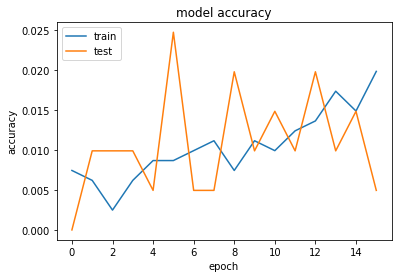

In [49]:
#Accuracyの推移
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.savefig(save_path + '/accuracy.png')
#plt.close()

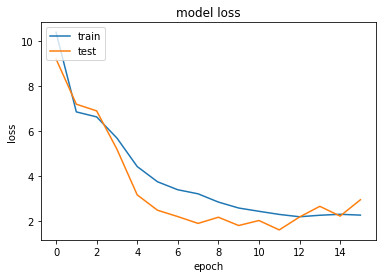

In [50]:
# Lossの推移
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.savefig(save_path + '/loss.png')
#plt.close()

In [51]:
# モデルと学習結果を保存する
model_json_str = model.to_json()
open('Keras_rnn.json', 'w').write(model_json_str)
model.save_weights('Keras_rnn_weights.h5');

In [52]:
#ここから予測

# 気象データを取得
dfWeatherTest = get_dfWeather_data_test()
# 学習用データを取得(日付順にソート)
#dfWeatherTest = dfWeather.ix['2017-12-01':'2018-11-30', 1]
#dfWeatherTrain = dfWeatherTrain.sort_index()
#dfWeatherTest = dfWeatherTest.dropna() # 欠損値のある行を取り除く
# 温度だけ
dfWeatherTest = pd.DataFrame(dfWeather[1].dropna()) # 欠損値のある行を取り除く

X_test, Y_test, Y_test_date = generate_data(dfWeatherTest, LENGTH_PER_UNIT, DIMENSION)
# 正規化
X_test /= np.nanmax(np.abs(X_test))

C:\Users\fujii\Anaconda3\envs\tesorflow-gpu\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
C:\Users\fujii\Anaconda3\envs\tesorflow-gpu\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [53]:
import keras

# モデルを読み込む
model = keras.models.model_from_json(open('Keras_rnn.json').read())

# 学習結果を読み込む
model.load_weights('Keras_rnn_weights.h5')

# モデルの要約を出力
model.summary()

# モデルのコンパイル
model.compile(optimizer = optimizers.Adam(),        # 最適化手法
              loss = 'mean_squared_error',           # 損失関数
              metrics = ['accuracy']) # 評価関数

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_11 (GRU)                 (None, 90, 32)            3264      
_________________________________________________________________
gru_12 (GRU)                 (None, 64)                18624     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 21,953
Trainable params: 21,953
Non-trainable params: 0
_________________________________________________________________


In [54]:
#len(X_test)
#X_test
X_test[0].size

90

'\nfor i in range(0, len(X_test)):\n#for i in range(0, X_test[0].size):\n    y_ = model.predict(X_test[i:i+1, :, :])\n    tmp = np.array([float(y_), float(Y_test[i:i+1, :]), abs(float(y_) - float(Y_test[i:i+1, :]))])\n    tmp = np.ravel(tmp)\n    dfResult = pd.DataFrame([tmp], columns=df_columns, index=[Y_test_date[i:i+1]])    \n    dfResultWeather = dfResultWeather.append(dfResult)\n'

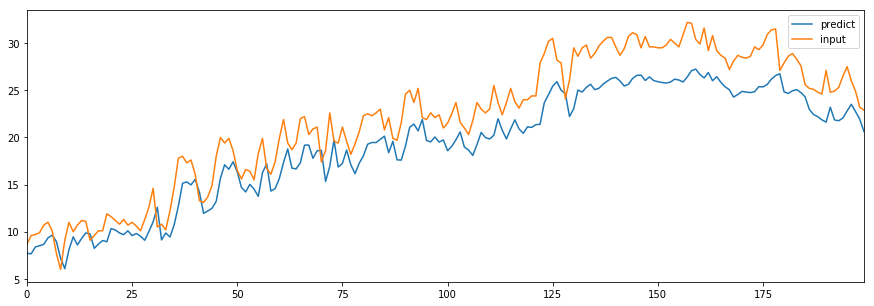

In [55]:
df_columns = ['予測', '実測値', '差(予測-実測値)']

predicted = model.predict(X_test)

dataf =  pd.DataFrame(predicted[:200])
dataf.columns = ["predict"]
dataf["input"] = Y_test[:200]
dataf.plot(figsize=(15, 5))

# 予測を行う
'''
for i in range(0, len(X_test)):
#for i in range(0, X_test[0].size):
    y_ = model.predict(X_test[i:i+1, :, :])
    tmp = np.array([float(y_), float(Y_test[i:i+1, :]), abs(float(y_) - float(Y_test[i:i+1, :]))])
    tmp = np.ravel(tmp)
    dfResult = pd.DataFrame([tmp], columns=df_columns, index=[Y_test_date[i:i+1]])    
    dfResultWeather = dfResultWeather.append(dfResult)
'''

In [17]:
pd.DataFrame(predicted).tail(7)

,0
971,11.934628
972,13.356306
973,14.402940
974,14.172196
975,13.542620
976,12.539425
977,11.169689


In [19]:
pd.DataFrame(Y_test).tail()

,0
973,14.5
974,14.1
975,12.3
976,10.4
977,11.2


In [39]:
dfWeatherTrain.describe()

,1,4,7,10,14,26,29,34,37,40,43,46,49,52,60,63
count,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000
mean,17.787067,14.431694,21.876594,4.197177,5.638069,2.806740,6.283880,15.858652,1013.806193,68.937158,50.230419,6.821311,14.134199,10.200273,1015.582058,1013.203461
std,7.900837,8.075171,8.222235,13.677812,4.216780,1.087113,1.891492,8.511089,7.085036,11.620977,13.672718,2.936720,7.925548,3.544777,7.138185,7.400842
min,0.500000,-1.800000,2.300000,0.000000,0.000000,0.800000,2.000000,3.300000,984.600000,37.000000,12.000000,0.000000,0.890000,3.100000,986.300000,983.500000
25%,10.600000,7.100000,14.900000,0.000000,1.400000,2.100000,5.100000,8.300000,1008.600000,61.000000,41.000000,5.000000,7.170000,7.700000,1010.300000,1008.000000
50%,17.900000,14.500000,22.400000,0.000000,5.700000,2.500000,6.000000,13.900000,1013.800000,69.000000,50.000000,7.500000,13.370000,9.450000,1015.600000,1013.300000
75%,24.300000,21.000000,28.600000,2.000000,9.300000,3.300000,7.200000,22.875000,1019.300000,77.000000,59.000000,9.500000,20.552500,12.000000,1021.100000,1018.775000
max,32.800000,30.500000,38.300000,236.000000,13.500000,9.500000,19.000000,34.400000,1030.400000,98.000000,93.000000,10.000000,30.090000,34.900000,1032.300000,1030.400000


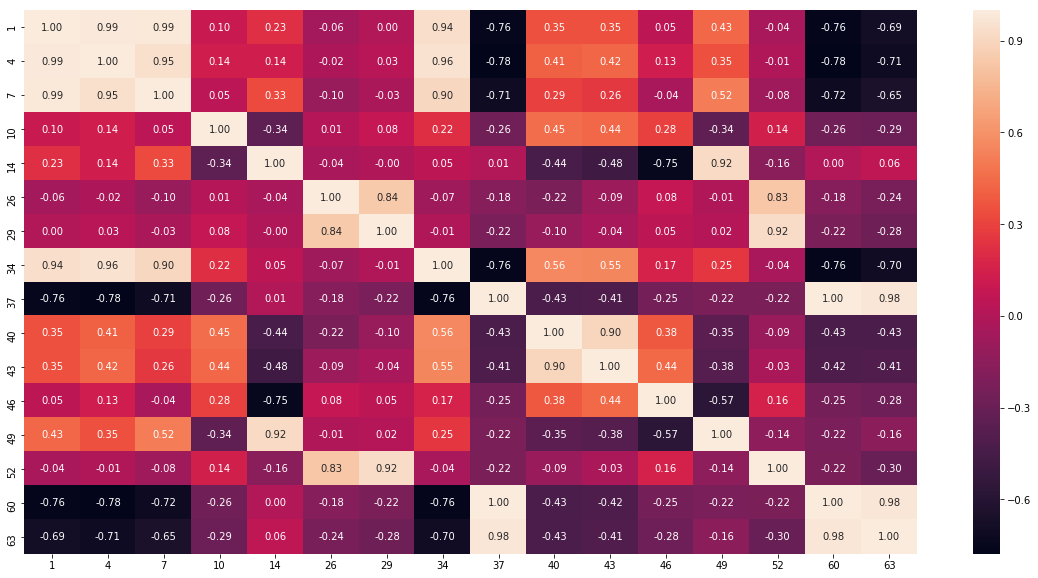

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 10))
sns.heatmap(dfWeatherTrain.corr(), annot=True, fmt='.2f')

In [45]:
from sklearn.feature_selection import SelectKBest, f_classif

possible_features = dfWeatherTrain.columns.copy().drop(1)

# Check feature importances
# f_classifは標準の指標のようなもの
selector = SelectKBest(f_classif, len(possible_features))
selector.fit(dfWeatherTrain[possible_features], dfWeatherTrain[1])
scores = -np.log10(selector.pvalues_)
indices = np.argsort(scores)[::-1]

print('Feature importances:')
for i in range(len(scores)):
    print('%.2f %s' % (scores[indices[i]], possible_features[indices[i]]))

Feature importances:
inf 34
inf 7
inf 4
92.22 60
90.56 37
62.55 63
15.46 49
8.68 40
6.33 43
5.13 14
2.05 26
1.87 46
1.04 10
0.53 52
0.51 29


C:\Users\fujii\Anaconda3\envs\tesorflow-gpu\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


In [54]:
pd.DataFrame(features_pca).head()

,0,1,2,3,4,5,6,7,8,9
0,-1.030553,0.689034,-0.891474,-0.315882,-0.404779,0.990347,-0.002922,0.000700,-0.099607,1.323329
1,-0.843455,1.004012,-0.249403,-0.985475,-0.591081,1.553890,0.274320,-0.245322,0.137049,1.177505
2,-1.303514,0.052012,0.077660,0.821007,-1.096281,0.978969,-0.509672,0.943807,-1.636883,0.626074
3,-1.361807,-0.396230,-1.363805,0.392410,0.351022,-0.141339,0.973508,-0.046046,2.515068,0.396071
4,-0.296238,1.440489,-1.369889,0.167625,-0.377424,-1.354125,0.307347,0.235794,-0.045528,1.029665


In [59]:
#possible_features
#features_pca
len(pd.DataFrame(features_pca).columns)

10